# Synthetic Stock Price History
This notebook creates the synthetic prices history based on the signals generated in the [DRL-Portfolio-Optimization](https://github.com/daniel-fudge/DRL-Portfolio-Optimization/blob/master/data-preparation-no-memory.ipynb) repo.  

#### Load some necessary modules

In [129]:
from datetime import datetime, timedelta  
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

#### Set some local parameters

In [130]:
n_assets = 10
names = ['s{}'.format(n + 1) for n in range(n_assets)]

#### Load the previously generated signals

In [131]:
signals = pd.read_csv(os.path.join('container', 'src', 'signals.csv'), index_col='date')
n_days, n_signals = signals.shape
S = np.transpose(signals.values)
print('n_signals = {}'.format(n_signals))
print('n_days = {}'.format(n_days))
signals.describe()

n_signals = 71
n_days = 2922


,sma20_AAP,sma20_ACN,sma20_ADBE,sma20_AFL,sma20_ALB,sma20_ALK,sma20_AOS,sma20_ATVI,sma20_AYI,sma20_MMM,...,pe_AAP,pe_ACN,pe_ADBE,pe_AFL,pe_ALB,pe_ALK,pe_AOS,pe_ATVI,pe_AYI,pe_MMM
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,...,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,0.000000,0.000342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000342,...,-0.485775,-0.481396,0.612901,-0.888697,-0.446303,-0.823752,-0.478290,0.117157,-0.126282,-0.596048
std,0.345163,0.343672,0.350087,0.346153,0.340167,0.335097,0.347141,0.353977,0.348126,0.339664,...,0.348208,0.391769,0.556072,0.292847,0.497739,0.373862,0.391707,0.737688,0.666345,0.293470
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.955033,-0.959684,-0.795938,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.927838,-0.946089
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.762030,-0.788139,0.200376,-1.000000,-0.814655,-1.000000,-0.739272,-0.627677,-0.736739,-0.817477
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.534241,-0.608897,1.000000,-1.000000,-0.564026,-0.950029,-0.610155,0.099663,-0.378700,-0.635709
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.305513,-0.288091,1.000000,-0.897082,-0.238175,-0.818882,-0.260654,1.000000,0.419261,-0.447480
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.973759,1.000000,0.998474,1.000000,1.000000,1.000000,1.000000,1.000000,0.942279


## Create the Deterministic Time-Invariant Pricing (p1)
The pricing function will follow the relation below.

$
\mathbf{\Delta p}_i = \mathbf{As}_i + \mathbf{B}(\mathbf{s}_i-\mathbf{s}_{i-h})h^{-1} + \mathbf{C}(\mathbf{s}_i-2\mathbf{s}_{i-h} + \mathbf{s}_{i-2h})h^{-2} \\
\mathbf{p}_{i+1} = \mathbf{p}_i + \mathbf{\Delta p}_i \\
\text{where:} \\
\qquad \mathbf{\Delta p}_i \text{ is the [}n_a, 1 \text{] change in price vector at day } i  \\
\qquad \mathbf{p}_i \text{ is a [}n_a, 1 \text{] price vector at day } i \\
\qquad \mathbf{A}, \mathbf{B}, \mathbf{C} \text{ are [}n_a, n_s \text{] matrix of constants on [-1, 1]} \\
\qquad \mathbf{s}_i \text{ is a [}n_s, 1 \text{] signal vector at day } i \\
\qquad n_a \text{ is the number of assets in the portfolio excluding cash } \\
\qquad n_s \text{ is the number of signals defining the environment } \\
\qquad i \in \text{[0, number of days - 1]} \\
\qquad h \text{ is the step sized used to calculate the 1st and 2nd derivatives} \\
$

#### Create the constant coefficients
Note we will force the mean to zero and range to [-1, 1]$\frac{1}{n_s}$.

In [132]:
A = 2*np.random.rand(n_assets, n_signals) - 1
B = 2*np.random.rand(n_assets, n_signals) - 1
C = 2*np.random.rand(n_assets, n_signals) - 1

A = A - A.mean()
B = B - B.mean()
C = C - C.mean()

A = A/np.abs(A).max()/n_signals
B = B/np.abs(B).max()/n_signals
C = C/np.abs(C).max()/n_signals

#### Create the approximations the 1st and 2nd derivatives

In [133]:
h = 5
# Roll the signals by h days and assume same price before i = 0
S_mh = np.roll(S, h, axis=1)
for i in range(h):
    S_mh[:, i] = S_mh[:, h]

# Roll the signals by another h days
S_m2h = np.roll(S_mh, h, axis=1)
for i in range(h):
    S_m2h[:, i] = S_m2h[:, h]
    
d1 = (S - S_mh)/h
d2 = (S - 2*S_m2h + S_mh)/(h*h)

#### Generate the synthetic price history
Note without a loss of generality we can assume the initial stock prices are zero.  Therefore the price history is simply a cumulative sum of $\mathbf{\Delta p}_i$.

Note you can rerun this notebook to get a more realistic _looking_ stock history.

In [134]:
p = np.cumsum(np.vstack([np.ones((1, n_assets)), np.transpose(A.dot(S) + B.dot(d1) + C.dot(d2))]), axis=0)
p.shape

(2923, 10)

#### Normalize the prices a little to make it realistic
All prices end between 0.1 and 10.  Also npte the extra price for the last projection.

In [135]:
for i in range(p.shape[1]):
    if p[-1, i] > 10:
        p[:, i] -= np.linspace(0, 1.0, p.shape[0]) * (p[-1, i] - 10)
    elif p[-1, i] < 0.1:
        p[:, i] += np.linspace(0, 1.0, p.shape[0]) * (0.1 - p[-1, i])

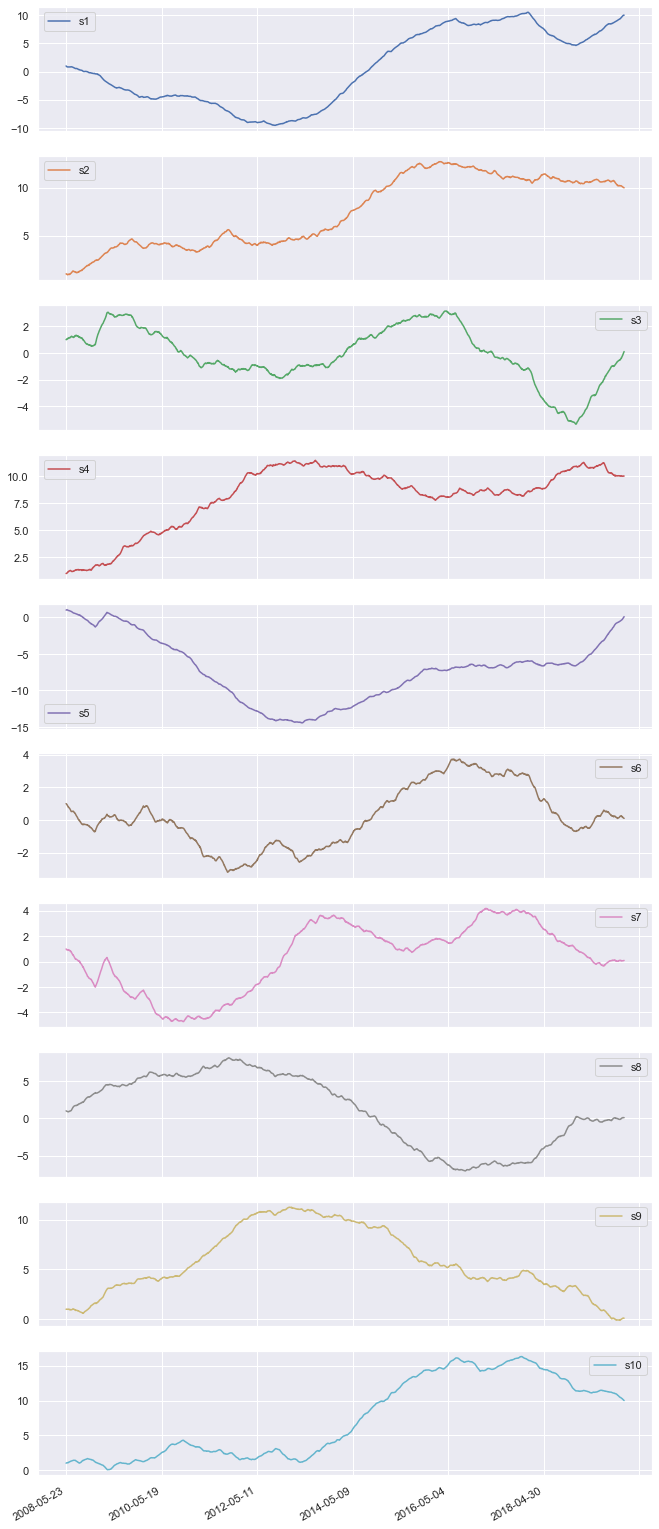

In [136]:
dates = signals.index.tolist()
dates.append((datetime.strptime(signals.index[-1], '%Y-%m-%d') + timedelta(days=1)).strftime("%Y-%m-%d"))
stocks = pd.DataFrame(index=dates, columns=names, data=p)
axes = stocks.plot(figsize=(11, 3*stocks.shape[1]), subplots=True)
plt.show()

#### Plot the synthetic market for fun

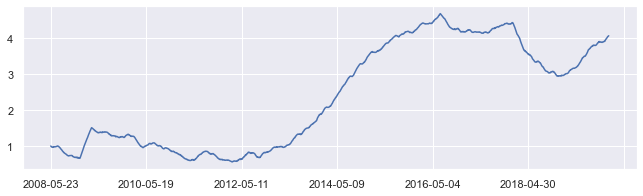

In [137]:
market = stocks.sum(axis=1) / stocks.shape[1]
axes = market.plot(figsize=(11, 3))
plt.show()

#### Save price history for training

In [138]:
stocks.to_csv(os.path.join('container', 'src', 'prices1.csv'))